# Assignment 3 - Instrument Detection Model 
Group 32 - Audio Insights


In [182]:
#!pip install -U -q tensorflow tensorflow_datasets
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

## Import require libraries

In [207]:
import os
import pathlib
import keras

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa


from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the seed value for experiment reproducibility.
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

## Import the IRMAS Data set

Download and extract the `IRMAS-TrainingData.zip` file containing the smaller Audio inserts datasets and set the path to the training data:


In [210]:
DATASET_PATH = 'data/IRMAS-TrainingData'
data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 11 folders corresponding to each of the 11 instruments (refer to output below):

In [185]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.txt') & (commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['pia' 'voi' 'tru' 'sax' 'org' 'cla' 'gac' 'vio' 'flu' 'gel' 'cel']


Access each folder and load the data for the respective instrument into a tensorflow dictionary:

In [186]:
# Define the length of data audio
fixed_length = 48000
# Define the directory containing the audio files
data_dir = data_dir

# Define the batch size and validation split
batch_size = 64
validation_split = 0.2

# Get a list of all the audio file paths in the directory
audio_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

# Get the class names from the subdirectories of the data directory
class_names = [dir for dir in os.listdir(data_dir) if dir != '.DS_Store']
num_classes = len(class_names)

label_names = np.array(class_names)
print("label names:", label_names)

# Define a function to load and preprocess each audio file
def load_audio(file_path):
    # Load the audio file using librosa
    signal, sr = librosa.load(file_path, sr=None, mono=False)

    # Pad or truncate the signal to a fixed length
    target_length = fixed_length
    if signal.shape[1] < target_length:
        signal = np.pad(signal, ((0, 0), (0, target_length - signal.shape[1])), mode="constant")
    else:
        signal = signal[:, :target_length]

    # Rescale the signal to be between -1 and 1
    signal = signal / np.max(np.abs(signal))
    return signal.T

# Split the audio files into training and validation sets
num_files = len(audio_files)
# Shuffle the audio files
np.random.shuffle(audio_files)

# Split the files into training and validation sets
split_index = int(num_files * (1 - validation_split))
train_files = audio_files[:split_index]
val_files = audio_files[split_index:]

# Create NumPy arrays for the input features and target labels
train_features = np.zeros((len(train_files), fixed_length, 2), dtype=np.float32)
train_labels = np.zeros((len(train_files),), dtype=np.int32)
for i, file_path in enumerate(train_files):
    train_features[i] = load_audio(file_path)
    train_labels[i] = class_names.index(os.path.basename(os.path.dirname(file_path)))

val_features = np.zeros((len(val_files), fixed_length, 2), dtype=np.float32)
val_labels = np.zeros((len(val_files),), dtype=np.int32)
for i, file_path in enumerate(val_files):
    val_features[i] = load_audio(file_path)
    val_labels[i] = class_names.index(os.path.basename(os.path.dirname(file_path)))

# Create TensorFlow Datasets for training and validation
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(batch_size)

label names: ['pia' 'voi' 'tru' 'sax' 'org' 'cla' 'gac' 'vio' 'flu' 'gel' 'cel']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [187]:
for waveform, sample_rate in train_ds.take(1):
    print("shape:", waveform.shape)
print(train_ds.element_spec)

shape: (64, 48000, 2)
(TensorSpec(shape=(None, 48000, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


The audio dataset consists of file with 2 channels (stereo), a function is created to convert to single channel (mono):

In [188]:
#def squeeze(audio, labels):
  #audio = tf.squeeze(audio, axis=-1)
  #return audio, labels
def squeeze_duel_channel(audio, labels):
  audio = tf.squeeze(tf.reduce_mean(audio, axis=-1, keepdims=True), axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze_duel_channel, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze_duel_channel, tf.data.AUTOTUNE)

In [189]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


`Dataset.shard` is used to split the validation set into two halves. One for validation and one for test:

In [190]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [191]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 48000)
(64,)


Let's plot a few audio waveforms:

In [192]:
label_names[[1,1,3,0]]

array(['voi', 'voi', 'sax', 'pia'], dtype='<U3')

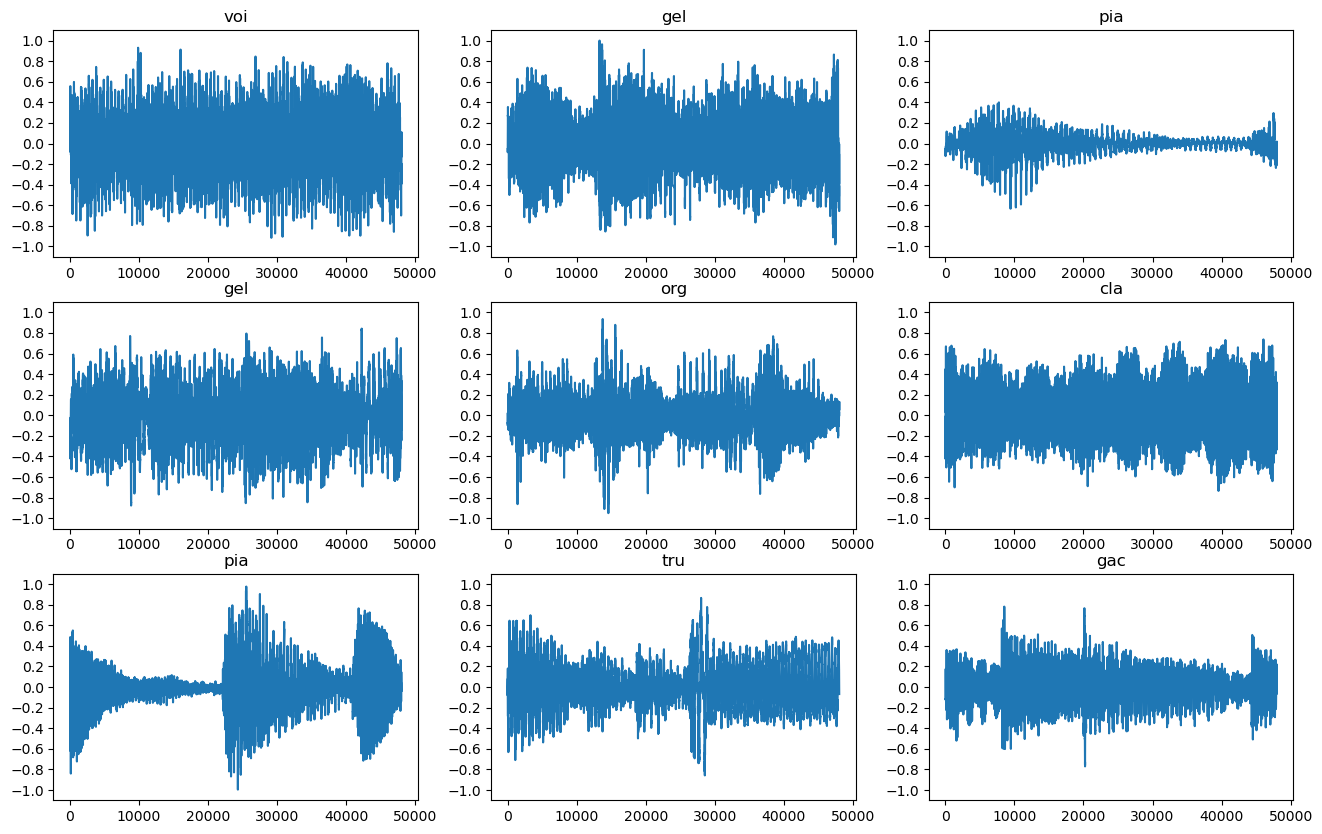

In [193]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

A function is created to convert the waveform to spectograms. This is done using STFT (`tf.signal.stft`) which splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

In [194]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Example of data with labels, waveform shape, spectrogram shape and the original audio:

In [195]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: voi
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: gel
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: pia
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Define a function for displaying a spectrogram:

In [196]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Example of converted spectrgrams in comparisons to the original waveform:

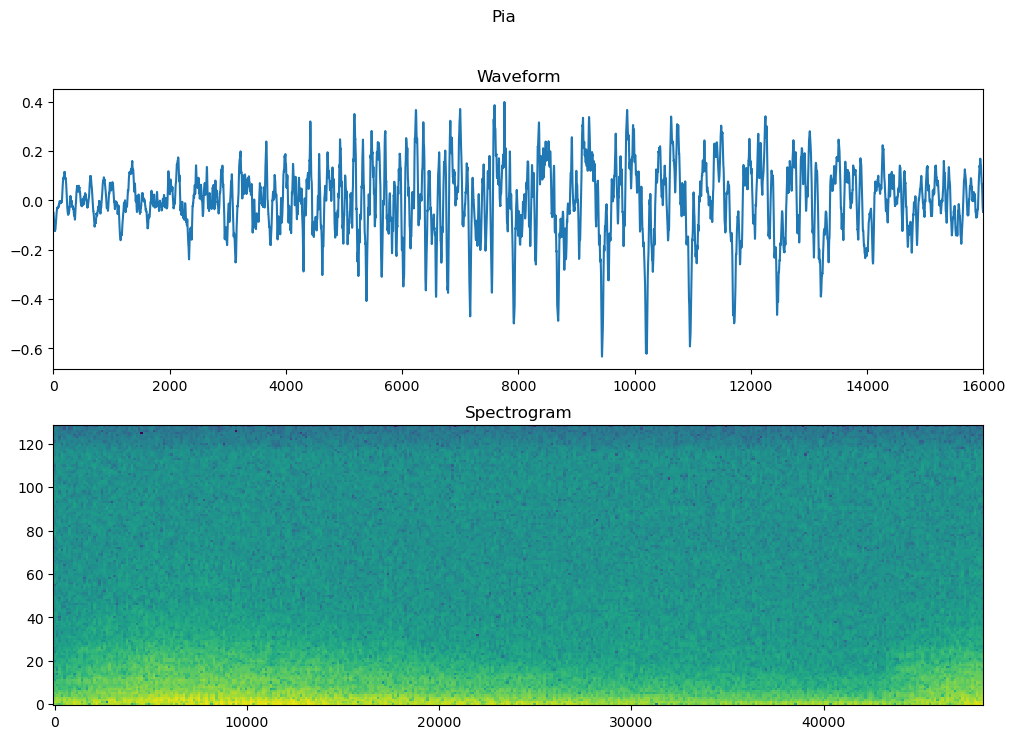

In [197]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogramn datasets from the audio datasets:

In [198]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [199]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different classes of the dataset:

In [200]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

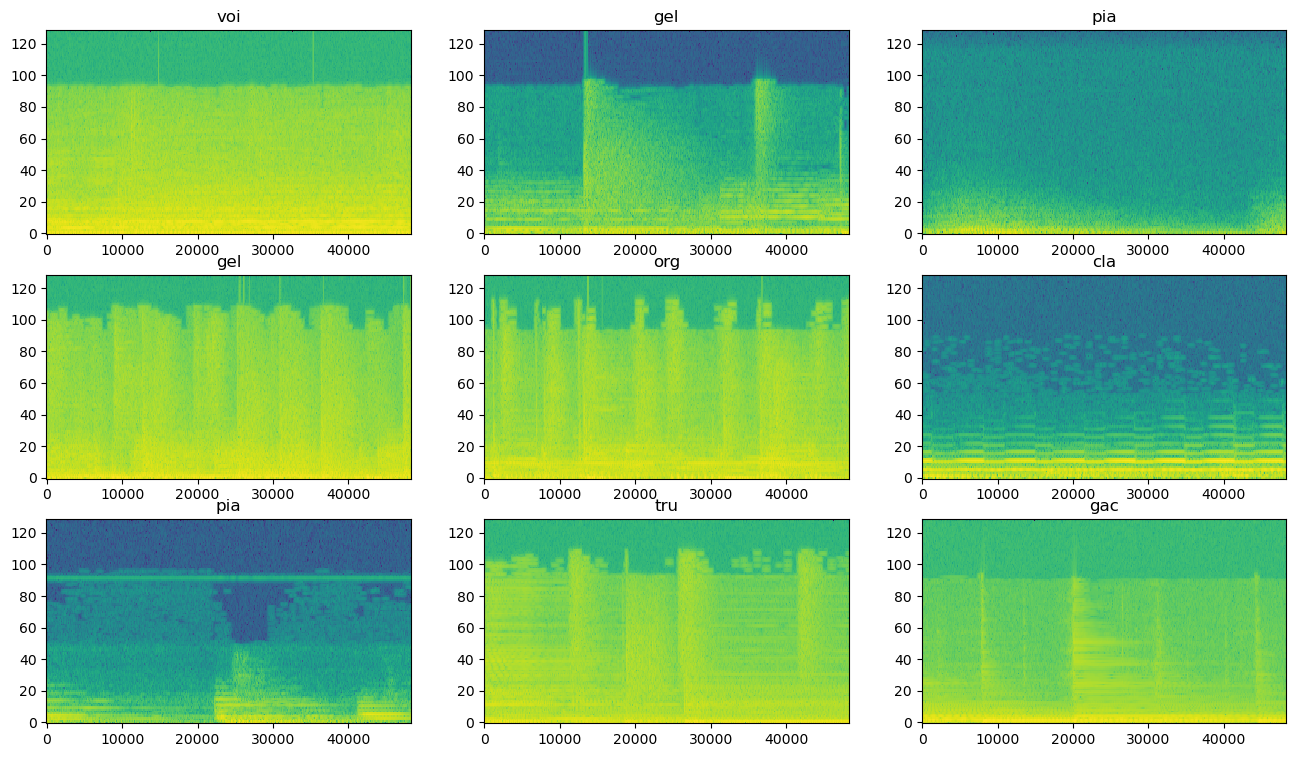

In [201]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Model Experimentation

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [202]:
train_spectrogram_dss = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_dss = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_dss = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### 1. Custom CNN Model

In [212]:

'''
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),    # Downsample the input.
    norm_layer,                 # Normalize.
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])



model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()
'''

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)       

### 2. Custom VGG16 Model

In [213]:
'''
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Load the pre-trained VGG16 model without the top classification layer
model = VGG16(weights='imagenet', include_top=False, input_shape=(374, 129, 3))

# Create a new input tensor with 3 channels by replicating the single-channel input
input_tensor = tf.keras.layers.Input(shape=(374, 129, 1))
x = tf.tile(input_tensor, [1, 1, 1, 3])

# Apply VGG16 model to the replicated input
x = model(x)

# Add your own classification layers on top of the base model
#x = tf.image.resize(x, (32, 32))
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
'''


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 374, 129, 1)]     0         
                                                                 
 tf.tile (TFOpLambda)        (None, 374, 129, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 11, 4, 512)        14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                          

### 3. Custom ResNet-50 Model (CHOSEN MODEL)

In [214]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(374, 129, 3))

# Unfreeze the ResNet50 layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True
    
# Create a new input tensor with 3 channels by replicating the single-channel input
input_tensor = tf.keras.layers.Input(shape=(374, 129, 1))
x = tf.repeat(input_tensor, repeats=3, axis=-1)

# Apply the ResNet50 model to the replicated input
x = base_model(x)

# Add your own custom layers
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Dropout(0.1)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.2)(x)
predictions = Dense(num_labels, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 374, 129, 1)]     0         
                                                                 
 tf.repeat_6 (TFOpLambda)    (None, 374, 129, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 12, 5, 2048)       23587712  
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 5, 128)        2359424   
                                                                 
 batch_normalization_20 (Bat  (None, 12, 5, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 5, 256)        295168    
                                                           

Training ResNet model:

In [51]:
# Define the checkpoint path
checkpoint_path = 'model_checkpoint.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)


EPOCHS = 100
history = model.fit(
    train_spectrogram_dss,
    validation_data=val_spectrogram_dss,
    epochs=EPOCHS,
    batch_size = 32,
    verbose = 1,
    callbacks=[checkpoint],
)


Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 2.2521 - accuracy: 0.2862
Epoch 1: val_loss improved from inf to 2.46980, saving model to model_checkpoint.h5
84/84 [==============================] - 113s 1s/step - loss: 2.2521 - accuracy: 0.2862 - val_loss: 2.4698 - val_accuracy: 0.1203
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 1.6313 - accuracy: 0.4814
Epoch 2: val_loss did not improve from 2.46980
84/84 [==============================] - 102s 1s/step - loss: 1.6313 - accuracy: 0.4814 - val_loss: 2.4900 - val_accuracy: 0.1219
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.5418
Epoch 3: val_loss did not improve from 2.46980
84/84 [==============================] - 99s 1s/step - loss: 1.4501 - accuracy: 0.5418 - val_loss: 2.8674 - val_accuracy: 0.1000
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 1.2807 - accuracy: 0.5818
Epoch 4: val_loss did not improve from 2.46980
84/84 

Visualisation of training and validation loss curves:

Text(0, 0.5, 'Accuracy [%]')

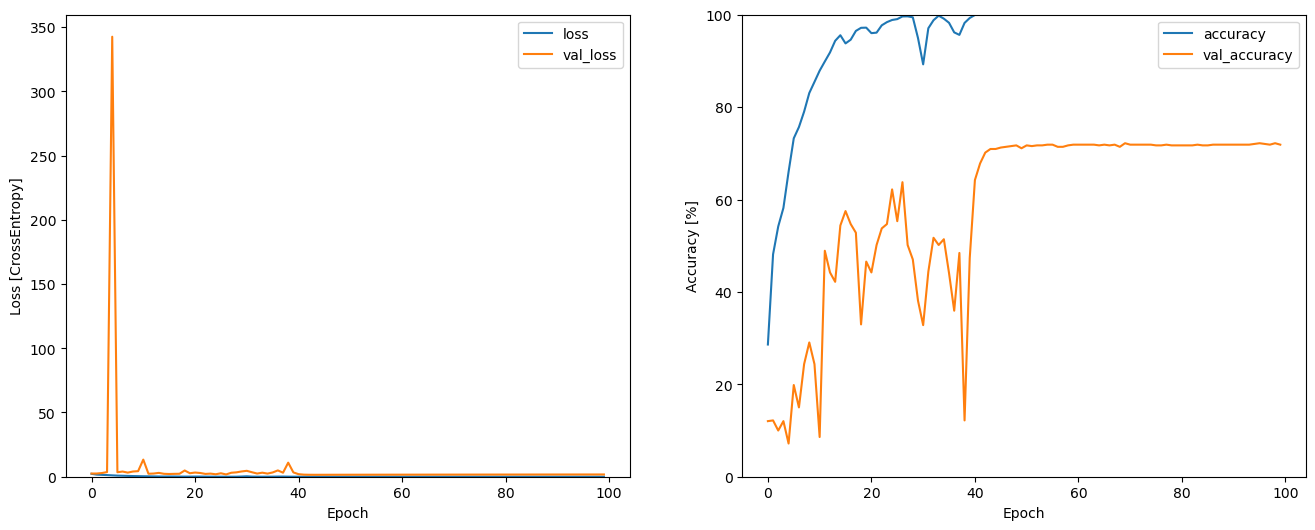

In [53]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [54]:
model.evaluate(test_spectrogram_dss, return_dict=True)

11/11 [==============================] - 6s 420ms/step - loss: 1.6998 - accuracy: 0.7347


{'loss': 1.6998190879821777, 'accuracy': 0.734664797782898}

### Display a confusion matrix

Use a confusion matrix to check how well the model did classifying each of the instruemnts in the test set:


In [55]:
y_pred = model.predict(test_spectrogram_dss)

11/11 [==============================] - 6s 379ms/step


In [57]:
y_pred = tf.argmax(y_pred, axis=1)

In [58]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

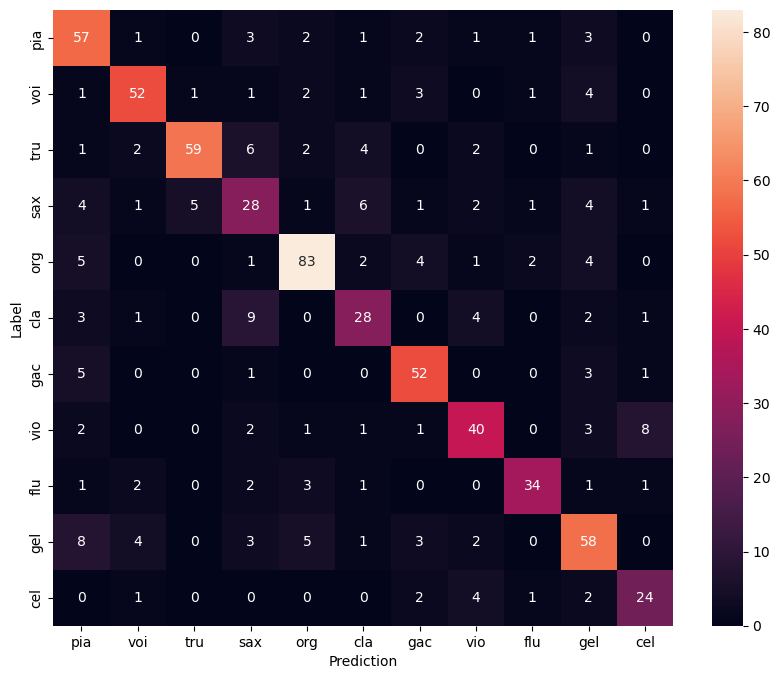

In [59]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

##vgg net model

## Run inference on an audio file

Verify the model's prediction output using an sample input audio file:

Predicted class ID: Voice
Predicted probability: 96.99%


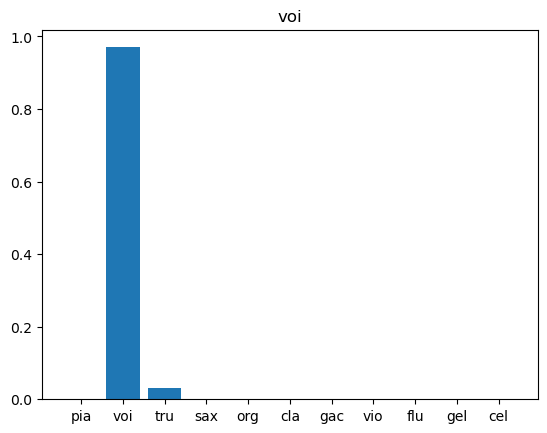

tf.Tensor(
[[2.8674801e-06 9.6990901e-01 3.0001299e-02 7.7912737e-05 1.6909969e-06
  5.9304068e-07 3.4944874e-06 1.4099668e-06 1.6348869e-06 3.8920696e-08
  8.9952138e-08]], shape=(1, 11), dtype=float32)


In [220]:

x = '/Users/yash/Git/Audio-Insights/Data/IRMAS-TrainingData/voi/[voi][jaz_blu]2358__2.wav'

model = keras.models.load_model('/Users/yash/Git/Audio-Insights/models/resnet_model_74v2.h5')

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000,)
x = tf.squeeze(tf.reduce_mean(x, axis=-1, keepdims=True), axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_labels = ['pia','voi' ,'tru' ,'sax', 'org', 'cla', 'gac', 'vio', 'flu', 'gel','cel']
label_names = ['Piano','Voice', 'Trumpet', 'Saxophone', 'Organ' ,'Clarinent' ,'Acoutic Guitar' ,'Violin', 'Flute', 'Electric Guitar', 'Cello']

prediction = model(x)
predicted_class_id = tf.argmax(prediction[0]).numpy()
predicted_probability = 100 * prediction[0][predicted_class_id].numpy()
print("Predicted class ID:", label_names[predicted_class_id])
print("Predicted probability:", '{:.2f}%'.format(predicted_probability))


#plt.bar(x_labels, prediction[0])
plt.bar(x_labels, prediction[0])
plt.title(x_labels[predicted_class_id])
plt.show()

display.display(display.Audio(waveform, rate=48000))
print(prediction)


## Model Exports:

### Model export excluding pre-processing
This mode requires a spectrogram input

In [ ]:
# model.save('./models/' + 'Resnet_model_74v2' + '.h5')

### Model export including pre-processing
The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [216]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 48000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [217]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'sax/[sax][cla]1573__1.wav')))

{'predictions': <tf.Tensor: shape=(1, 11), dtype=float32, numpy=
 array([[0.09030041, 0.05612864, 0.04558261, 0.0355663 , 0.11987116,
         0.10207155, 0.127744  , 0.0766692 , 0.16274476, 0.10068547,
         0.08263592]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([8])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Flute'], dtype=object)>}

Save the model:

In [ ]:
tf.saved_model.save(export, '/Users/yash/Git/Audio-Insights/models/Resnet_model_74(waveform input)')